In [1]:
import pandas as pd
import json
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import tweepy
import emoji
import nltk
import nest_asyncio
import string

from textblob import TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

nest_asyncio.apply()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\OpDoge\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
pd.set_option('display.max_columns', None)

# Load Data

In [6]:
def load_all_historical_data_csv():
    dataframes = []
    pattern = r"Historical30d_(\w+)\.csv"
    for filename in os.listdir("data"):
        match = re.search(pattern, filename)
        if match:
            profile = match.group(1)
            filepath = os.path.join("data", filename)
            df = pd.read_csv(filepath)
            df['username'] = profile  # Add a 'Profile' column to identify the data source
            dataframes.append(df)
    combined_df = pd.concat(dataframes, ignore_index=True)
    combined_df = combined_df[['username'] + list(combined_df.columns[:-1])]

    # somehow, extra spacing there
    combined_df['date'] = pd.to_datetime(combined_df['date'])
    combined_df['followers'] = combined_df[' followers']
    combined_df['following'] = combined_df[' following']
    combined_df['tweets'] = combined_df[' tweets']
    
    combined_df.drop([' followers', ' following', ' tweets'], axis=1, inplace=True)

    return combined_df

df_historical = load_all_historical_data_csv()
df_historical


,username,date,followers,following,tweets
0,HardDriveMag,2023-05-03,321290,939,13258
1,HardDriveMag,2023-05-04,321260,939,13264
2,HardDriveMag,2023-05-05,321226,938,13270
3,HardDriveMag,2023-05-06,321229,939,13275
4,HardDriveMag,2023-05-07,321252,939,13277
...,...,...,...,...,...
111,TheOnion,2023-05-29,11780112,6,98702
112,TheOnion,2023-05-30,11779278,6,98723
113,TheOnion,2023-05-31,11777176,6,98753
114,TheOnion,2023-06-01,11775909,6,98784


# Plots

### Audience Growth Rate

Audience Growth Rate = ((Ending Followers - Starting Followers) / Starting Followers) * 100

#### Net followers across 30 days 

In [15]:
df_historical

,username,date,followers,following,tweets
0,HardDriveMag,2023-05-03,321290,939,13258
1,HardDriveMag,2023-05-04,321260,939,13264
2,HardDriveMag,2023-05-05,321226,938,13270
3,HardDriveMag,2023-05-06,321229,939,13275
4,HardDriveMag,2023-05-07,321252,939,13277
...,...,...,...,...,...
111,TheOnion,2023-05-29,11780112,6,98702
112,TheOnion,2023-05-30,11779278,6,98723
113,TheOnion,2023-05-31,11777176,6,98753
114,TheOnion,2023-06-01,11775909,6,98784


In [7]:
print(df_historical.columns)

Index(['username', 'date', 'followers', 'following', 'tweets'], dtype='object')


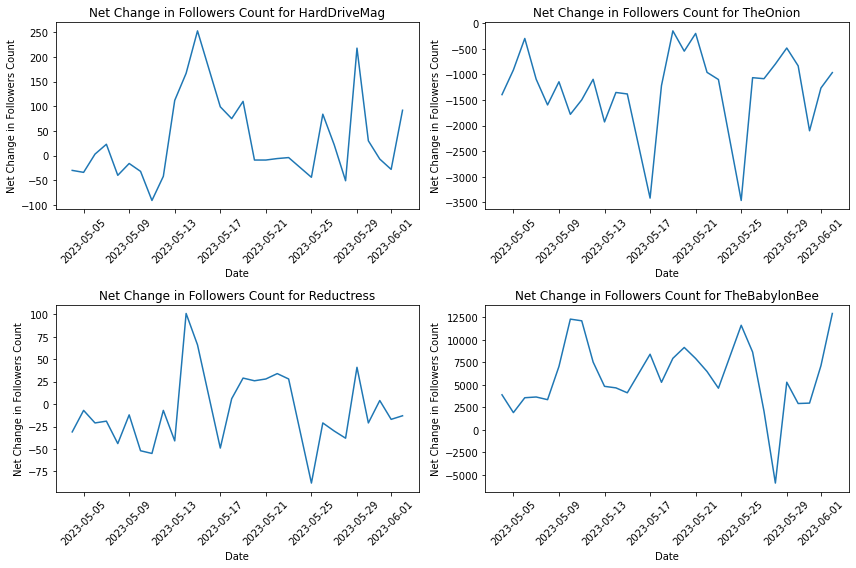

In [8]:
def plot_net_change_followers(combined_df):
    usernames = ['HardDriveMag', 'TheOnion', 'Reductress', 'TheBabylonBee']
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    for i, username in enumerate(usernames):
        row = i // 2
        col = i % 2
        df = combined_df[combined_df['username'] == username].copy() # it'll complain without copy() here
        df['net_change'] = df['followers'].diff()  # Calculate the net change
        ax = axes[row, col]
        ax.plot(df['date'], df['net_change'])
        ax.set_xlabel('Date')
        ax.set_ylabel('Net Change in Followers Count')
        ax.set_title(f'Net Change in Followers Count for {username}')
        ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

plot_net_change_followers(df_historical)

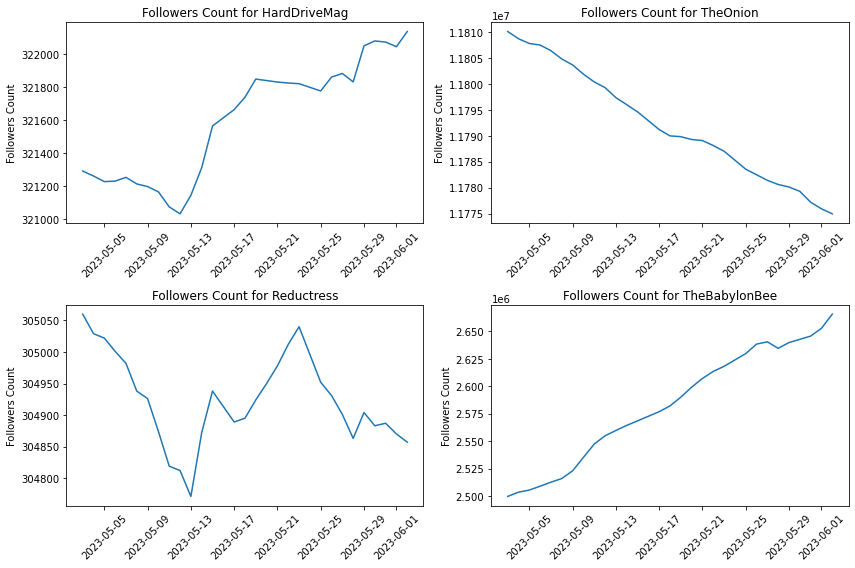

In [9]:
def plot_followers_count(combined_df):
    usernames = ['HardDriveMag', 'TheOnion', 'Reductress', 'TheBabylonBee']
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    for i, username in enumerate(usernames):
        row = i // 2
        col = i % 2
        df = combined_df[combined_df['username'] == username]
        ax = axes[row, col]
        ax.plot(df['date'], df['followers'])
        ax.set_ylabel('Followers Count')
        ax.set_title(f'Followers Count for {username}')
        ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

    # for username in usernames:
    #     df = combined_df[combined_df['username'] == username]
    #     plt.plot(df['date'], df['followers'])
    #     plt.xlabel('Date')
    #     plt.ylabel('Followers Count')
    #     plt.title(f'Followers Count for {username}')
    #     plt.xticks(rotation=45)
    #     plt.tight_layout()
    #     plt.show()


plot_followers_count(df_historical)

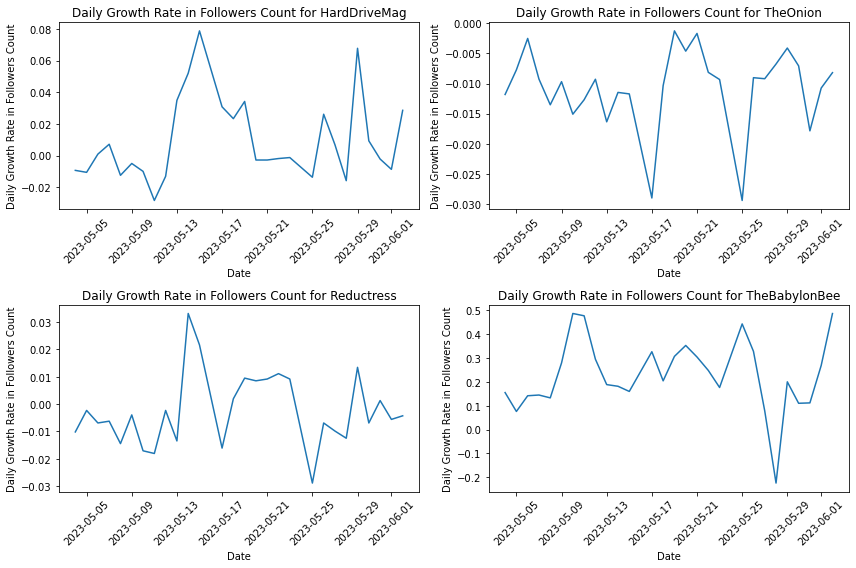

In [11]:
def plot_daily_change_followers(combined_df):
    usernames = ['HardDriveMag', 'TheOnion', 'Reductress', 'TheBabylonBee']
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    for i, username in enumerate(usernames):
        row = i // 2
        col = i % 2
        df = combined_df[combined_df['username'] == username].copy() # it'll complain without copy() here
        df['growth_rate'] = df['followers'].pct_change() * 100  # Calculate the net change
        ax = axes[row, col]
        ax.plot(df['date'], df['growth_rate'])
        ax.set_xlabel('Date')
        ax.set_ylabel('Daily Growth Rate in Followers Count')
        ax.set_title(f'Daily Growth Rate in Followers Count for {username}')
        ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

plot_daily_change_followers(df_historical)

In [18]:
def get_total_growth_rate_follower(df_combined):
    usernames = df_combined['username'].unique()
    df = pd.DataFrame(usernames, columns=['username'])
    total_growth_rates = {}
    for username in usernames:
        user_df = df_combined[df_combined['username'] == username]
        followers_start = user_df.iloc[0]['followers']
        followers_end = user_df.iloc[-1]['followers']
        total_growth_rate = ((followers_end - followers_start) / followers_start) * 100
        total_growth_rates[username] = total_growth_rate
    return total_growth_rates
        

        

list_total_growth_rate = get_total_growth_rate_follower(df_historical)

print(f"Total growth rate for followers across 30 days")
for username, growth_rate in list_total_growth_rate.items():
    print(f"{username}: {growth_rate:.2f}%")


Total growth rate for followers across 30 days
HardDriveMag: 0.26%
Reductress: -0.07%
TheBabylonBee: 6.65%
TheOnion: -0.30%
